# Galaxy10 + ResNet18

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
BASE = Path().resolve().parent
print(f'BASE: {BASE}')

import torch
torch.manual_seed(0)

IS_MPS_AVAILABLE = torch.backends.mps.is_available() and torch.backends.mps.is_built()
print(f'Is mps avaliable? : {IS_MPS_AVAILABLE}')
if not IS_MPS_AVAILABLE:
    IS_CUDA_AVAILABLE = torch.cuda.is_available()
    print(f'Is cuda avaliable? : {IS_CUDA_AVAILABLE}')
    print(f'cuda device count: {torch.cuda.device_count()}')
    print(f'cuda current device: {torch.cuda.current_device()}')
    print(f'cuda device name: {torch.cuda.get_device_name()}')
    # switch to cuda if available, else mps, else cpu
    DEVICE = torch.device('cuda' if IS_CUDA_AVAILABLE else 'cpu')
    print(f'device: {DEVICE}')

import h5py
from tqdm import tqdm

from sklearn.model_selection import train_test_split


BASE: C:\Users\zheng\Documents\GitHub\SDSSGalCat
Is mps avaliable? : False
Is cuda avaliable? : True
cuda device count: 1
cuda current device: 0
cuda device name: NVIDIA GeForce RTX 4060 Ti
device: cuda


In [2]:
# load data
# data ref: https://astronn.readthedocs.io/en/stable/galaxy10sdss.html

with h5py.File(BASE / 'data/Galaxy10.h5', 'r') as f:
    images = f['images'][:]
    labels = f['ans'][:]

print(f'images.shape: {images.shape}, labels.shape: {labels.shape}')
assert images.shape[0] == labels.shape[0]

images.shape: (21785, 69, 69, 3), labels.shape: (21785,)


images.shape: (87140, 69, 69, 3), labels.shape: (87140,)
images.shape: (174280, 69, 69, 3), labels.shape: (174280,)


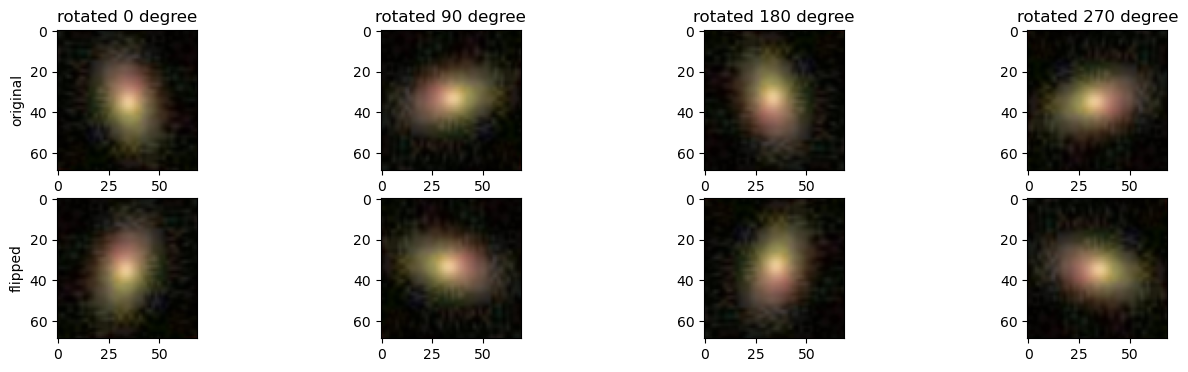

In [3]:
# enlarge the dataset: rotating the images by 90, 180, 270 degrees
images_enlarged = np.concatenate([images, np.rot90(images, k=1, axes=(1, 2)), np.rot90(images, k=2, axes=(1, 2)), np.rot90(images, k=3, axes=(1, 2))])
labels_enlarged = np.concatenate([labels, labels, labels, labels])
print(f'images.shape: {images_enlarged.shape}, labels.shape: {labels_enlarged.shape}')

# flip the images horizontally
images_flipped = np.flip(images_enlarged, axis=2)
images_enlarged_flipped = np.concatenate([images_enlarged, images_flipped])
labels_enlarged_flipped = np.concatenate([labels_enlarged, labels_enlarged])
print(f'images.shape: {images_enlarged_flipped.shape}, labels.shape: {labels_enlarged_flipped.shape}')

fig, axs = plt.subplots(2, 4, figsize=(16, 4))
# for i, ax in enumerate(axs):
#     ax.imshow(images_enlarged[i*images.shape[0]], cmap='gray')
#     ax.set_title(f'rotated {i*90} degree')
for i, ax in enumerate(axs[0]):
    ax.imshow(images_enlarged[i*images.shape[0]], cmap='gray')
    ax.set_title(f'rotated {i*90} degree')
    if i == 0:
        ax.set_ylabel('original')
for i, ax in enumerate(axs[1]):
    ax.imshow(images_flipped[i*images.shape[0]], cmap='gray')
    if i == 0:
        ax.set_ylabel('flipped')
plt.show()
plt.close()

del images_enlarged, labels_enlarged, images_flipped

images.shape: (34928, 69, 69, 3), labels.shape: (34928,)


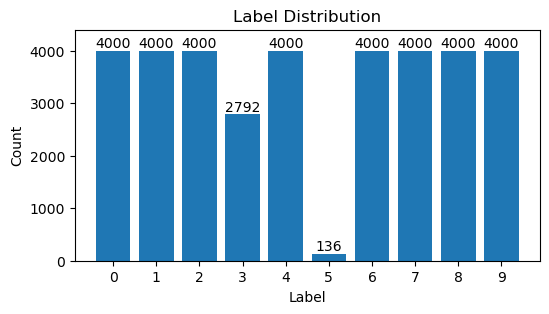

In [4]:
# balance the sample: select at most 1000 samples for each class
np.random.seed(0)
n_samples = 4000
images_balanced = []
labels_balanced = []
for i in range(10):
    if n_samples > np.sum(labels_enlarged_flipped == i):
        images_balanced.append(images_enlarged_flipped[labels_enlarged_flipped == i])
        labels_balanced.append(labels_enlarged_flipped[labels_enlarged_flipped == i])
        continue
    idx = np.where(labels_enlarged_flipped == i)[0]
    idx = np.random.choice(idx, n_samples, replace=False)
    images_balanced.append(images_enlarged_flipped[idx])
    labels_balanced.append(labels_enlarged_flipped[idx])
images_balanced = np.concatenate(images_balanced)
labels_balanced = np.concatenate(labels_balanced)
print(f'images.shape: {images_balanced.shape}, labels.shape: {labels_balanced.shape}')

# show distribution
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.bar(range(10), np.histogram(labels_balanced, bins=10)[0])
ax.set_title('Label Distribution')
ax.set_xlabel('Label')
ax.set_ylabel('Count')
ax.set_xticks(range(10))
for i in range(10):
    ax.text(i, np.sum(labels_balanced == i), f'{np.sum(labels_balanced == i)}', ha='center', va='bottom')
ax.set_ylim(0, 1.1*np.max(np.histogram(labels_balanced, bins=10)[0]))
plt.show()
plt.close()

In [5]:
# preprocess, required by resnet. 
# ref: https://pytorch.org/hub/pytorch_vision_resnet/
from torchvision import transforms
from PIL import Image
preprocess = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# try on larger batch
img_lst = [Image.fromarray(img, mode='RGB') for img in tqdm(images_balanced, total=len(images_balanced))]
input_tensor_lst = [preprocess(img) for img in tqdm(img_lst, total=len(img_lst))]

100%|██████████| 34928/34928 [00:31<00:00, 1115.25it/s]


In [6]:
# split the data, 90% for training and 10% for testing
# make sure that there are equal number of samples for each class in the training and testing set
X_train, X_test, y_train, y_test = train_test_split(torch.cat([t.unsqueeze(0) for t in input_tensor_lst]), labels_balanced, test_size=0.1, stratify=labels_balanced, random_state=0)
print(f'X_train.shape: {X_train.shape}, y_train.shape: {y_train.shape}')
print(f'X_test.shape: {X_test.shape}, y_test.shape: {y_test.shape}')

del images_enlarged_flipped, labels_enlarged_flipped, img_lst, input_tensor_lst

X_train.shape: torch.Size([31435, 3, 224, 224]), y_train.shape: (31435,)
X_test.shape: torch.Size([3493, 3, 224, 224]), y_test.shape: (3493,)


In [7]:
# build the resnet18
class MyResNET18(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.output = torch.nn.Linear(1000, 10)
        self.resnet18 = torch.hub.load('pytorch/vision:v0.18.0', 'resnet18', pretrained=True)

    def forward(self, x):
        x = torch.nn.functional.relu(self.resnet18(x))
        x = self.output(x)
        return x

my_resnet18 = MyResNET18()
if IS_CUDA_AVAILABLE:
    my_resnet18 = my_resnet18.to(DEVICE)

Using cache found in C:\Users\zheng/.cache\torch\hub\pytorch_vision_v0.18.0
e:\Anaconda\envs\torch230\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
e:\Anaconda\envs\torch230\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
# define the optimizer and loss function
crit = torch.nn.CrossEntropyLoss()
optim = torch.optim.SGD(my_resnet18.parameters(), lr=0.001, momentum=0.9)

In [9]:
EPOCH_NUM = 16
BATCH_SIZE = 64
if IS_CUDA_AVAILABLE:
    BATCH_SIZE = 128

# train the model
loss_history = []
for epoch in range(EPOCH_NUM):
    running_loss = 0.0
    for i in tqdm(
            range(0, X_train.shape[0], BATCH_SIZE), 
            # show running loss
            desc=f'Epoch {epoch+1}/{EPOCH_NUM}',
            total=X_train.shape[0]//BATCH_SIZE, 
            # realtime progress bar
            dynamic_ncols=True,
        ):
        # transpose the data to torch 
        this_inputs = X_train[i:i+BATCH_SIZE].float()
        this_labels = torch.tensor(y_train[i:i+BATCH_SIZE]).long()

        if IS_CUDA_AVAILABLE:
            this_inputs = this_inputs.to(DEVICE)
            this_labels = this_labels.to(DEVICE)

        optim.zero_grad()

        outputs = my_resnet18(this_inputs)
        loss = crit(outputs, this_labels)
        loss.backward()
        optim.step()

        loss_history.append(loss.item())
        running_loss += loss.item()

    print(f'Epoch {epoch+1} loss: {running_loss / (X_train.shape[0] / BATCH_SIZE)}')

Epoch 1/16: 100%|██████████| 245/245 [00:58<00:00,  4.30it/s]e:\Anaconda\envs\torch230\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
Epoch 1/16: 246it [00:58,  4.20it/s]                         


Epoch 1 loss: 1.0160795510014309


Epoch 2/16: 246it [00:53,  4.56it/s]                         


Epoch 2 loss: 0.5794109244367097


Epoch 3/16: 246it [00:53,  4.56it/s]                         


Epoch 3 loss: 0.4357758091992863


Epoch 4/16: 246it [00:53,  4.56it/s]                         


Epoch 4 loss: 0.33396818410692297


Epoch 5/16: 246it [00:53,  4.56it/s]                         


Epoch 5 loss: 0.24576118648839107


Epoch 6/16: 246it [00:53,  4.56it/s]                         


Epoch 6 loss: 0.17243927173969456


Epoch 7/16: 246it [00:53,  4.57it/s]                         


Epoch 7 loss: 0.12222113652545583


Epoch 8/16: 246it [00:53,  4.57it/s]                         


Epoch 8 loss: 0.09529056544521569


Epoch 9/16: 246it [00:53,  4.56it/s]                         


Epoch 9 loss: 0.07820343383454131


Epoch 10/16: 246it [00:53,  4.56it/s]                         


Epoch 10 loss: 0.06981750646493802


Epoch 11/16: 246it [00:53,  4.57it/s]                         


Epoch 11 loss: 0.057815443496740504


Epoch 12/16: 246it [00:53,  4.57it/s]                         


Epoch 12 loss: 0.03815605200131481


Epoch 13/16: 246it [00:53,  4.57it/s]                         


Epoch 13 loss: 0.026843758952509567


Epoch 14/16: 246it [00:53,  4.57it/s]                         


Epoch 14 loss: 0.017030321864382497


Epoch 15/16: 246it [00:53,  4.57it/s]                         


Epoch 15 loss: 0.011121780680457265


Epoch 16/16: 246it [00:53,  4.57it/s]                         

Epoch 16 loss: 0.0061139090450935945


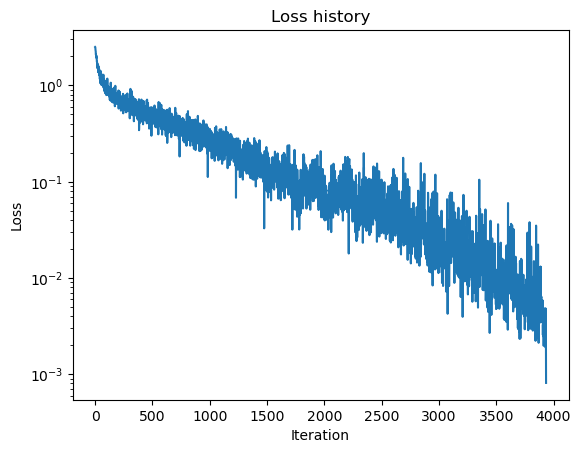

In [10]:
# show history
plt.plot(loss_history)
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.yscale('log')
plt.show()
plt.close()

e:\Anaconda\envs\torch230\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


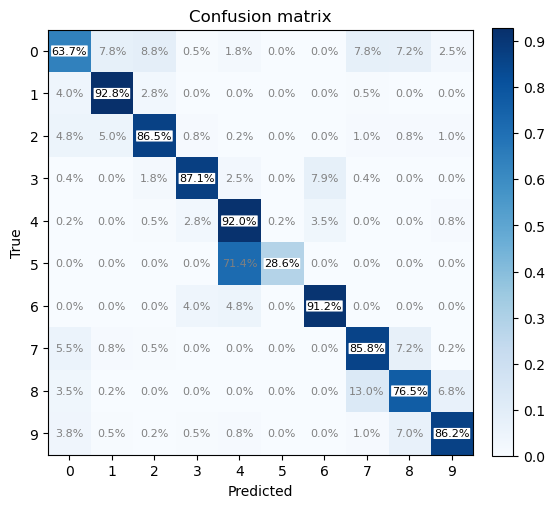

Overall Precision: 0.839, Recall: 0.790, F score: 0.802
   Class  Precision    Recall   F score
0      0   0.743440  0.637500  0.686406
1      1   0.866822  0.927500  0.896135
2      2   0.860697  0.865000  0.862843
3      3   0.877256  0.870968  0.874101
4      4   0.886747  0.920000  0.903067
5      5   0.800000  0.285714  0.421053
6      6   0.910224  0.912500  0.911361
7      7   0.784897  0.857500  0.819594
8      8   0.774684  0.765000  0.769811
9      9   0.884615  0.862500  0.873418


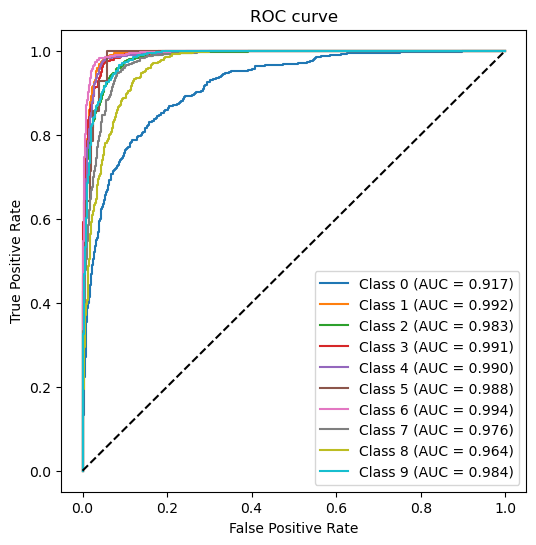

In [11]:
# confusion matrix
from sklearn.metrics import confusion_matrix

with torch.no_grad():
    test_inputs = X_test.float()
    test_labels = torch.tensor(y_test).long()

    if IS_CUDA_AVAILABLE:
        test_inputs = test_inputs.to(DEVICE)
        test_labels = test_labels.to(DEVICE)

    outputs = my_resnet18(test_inputs)
    _, predicted = torch.max(outputs, 1)

if IS_CUDA_AVAILABLE:
    y_outputs = outputs.cpu().numpy()
    y_pred = predicted.cpu().numpy()
else:
    y_outputs = outputs.numpy()
    y_pred = predicted.numpy()

confmat = confusion_matrix(y_test, y_pred, labels=range(10), normalize='true')

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
cax = ax.matshow(confmat, cmap='Blues')
# colorbar lim: 0-1
fig.colorbar(cax, fraction=0.046, pad=0.04, ticks=np.arange(0, 1.1, 0.1))
plt.title('Confusion matrix')
for i in range(10):
    for j in range(10):
        plt.text(j, i, f'{confmat[i, j]*100:.1f}%', ha='center', va='center', color='grey', fontsize=8)
plt.xticks(ticks=range(10), labels=range(10))
plt.yticks(ticks=range(10), labels=range(10))
# accuarcy for each label
for i in range(10):
    # text with border
    plt.text(i, i, f'{confmat[i, i]*100:.1f}%', ha='center', va='center', color='k', fontsize=8, bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.05'))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.gca().xaxis.set_ticks_position('bottom')
plt.show()
plt.close()

# precision, recall, F score
from sklearn.metrics import precision_recall_fscore_support
precision, recall, f_score, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')
print(f'Overall Precision: {precision:.3f}, Recall: {recall:.3f}, F score: {f_score:.3f}')

# for each class
precision, recall, f_score, _ = precision_recall_fscore_support(y_test, y_pred, average=None)
df_res = pd.DataFrame({
    'Class': range(10),
    'Precision': precision,
    'Recall': recall,
    'F score': f_score,
})
print(df_res)

# roc curve
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from scipy import interp

y_test_bin = label_binarize(y_test, classes=range(10))
y_outputs_bin = y_outputs
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(10):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_outputs_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
for i in range(10):
    ax.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.3f})')
ax.plot([0, 1], [0, 1], 'k--')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()
plt.close()